# Normal Inverse Gaussian Distribution

This notebook demonstrates the **Normal Inverse Gaussian (NIG)** distribution, a normal variance-mean mixture where the mixing distribution is Inverse Gaussian.

## Mathematical Definition

The Normal Inverse Gaussian distribution is defined as a normal mixture:

$$X | Y \sim N(\mu + \gamma Y, \Sigma Y)$$

$$Y \sim \text{InvGauss}(\delta, \eta)$$

where:
- $\mu \in \mathbb{R}^d$: location parameter
- $\gamma \in \mathbb{R}^d$: skewness parameter  
- $\Sigma \in \mathbb{R}^{d \times d}$: covariance scale matrix (positive definite)
- $\delta > 0$: Inverse Gaussian mean parameter (E[Y] = δ)
- $\eta > 0$: Inverse Gaussian shape parameter

## Key Properties

| Property | Formula |
|----------|--------|
| Mean | $E[X] = \mu + \gamma \delta$ |
| Covariance | $\text{Cov}[X] = \delta \Sigma + \frac{\delta^3}{\eta} \gamma \gamma^T$ |

## Distribution Types

- **Joint distribution** $f(x, y)$: Exponential family (tractable)
- **Marginal distribution** $f(x)$: NOT exponential family (requires EM for fitting)

## Special Case

NIG is a special case of the **Generalized Hyperbolic** distribution with GIG parameter $p = -1/2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats

from normix.distributions.mixtures import JointNormalInverseGaussian, NormalInverseGaussian
from normix.distributions.univariate import InverseGaussian
from normix.utils import (
    plot_joint_distribution_1d,
    plot_marginal_distribution_2d,
    validate_moments,
    print_moment_validation,
    fit_and_track_convergence,
    plot_em_convergence,
    test_joint_fitting,
    print_fitting_results
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Consistent styling
COLORS = {'primary': 'tab:blue', 'secondary': 'tab:red', 'tertiary': 'tab:green'}
np.set_printoptions(precision=4, suppress=True)

## Parameter Sets for Testing

We test with three different parameter configurations to demonstrate the distribution's flexibility.

In [2]:
# Define three parameter sets for comprehensive testing
PARAM_SETS = [
    {
        'name': 'Symmetric (γ=0)',
        'mu': np.array([0.0, 0.0]),
        'gamma': np.array([0.0, 0.0]),
        'sigma': np.array([[1.0, 0.3], [0.3, 1.0]]),
        'delta': 1.0,
        'eta': 1.0
    },
    {
        'name': 'Right-skewed (γ>0)',
        'mu': np.array([0.0, 0.0]),
        'gamma': np.array([0.5, 0.3]),
        'sigma': np.array([[1.0, 0.2], [0.2, 1.5]]),
        'delta': 1.5,
        'eta': 2.0
    },
    {
        'name': 'Left-skewed (γ<0)',
        'mu': np.array([1.0, -0.5]),
        'gamma': np.array([-0.4, 0.2]),
        'sigma': np.array([[2.0, -0.5], [-0.5, 1.0]]),
        'delta': 2.0,
        'eta': 1.5
    }
]

# Display parameter sets
for i, params in enumerate(PARAM_SETS):
    print(f"\nParameter Set {i+1}: {params['name']}")
    print(f"  μ = {params['mu']}")
    print(f"  γ = {params['gamma']}")
    print(f"  δ = {params['delta']}, η = {params['eta']}")


Parameter Set 1: Symmetric (γ=0)
  μ = [0. 0.]
  γ = [0. 0.]
  δ = 1.0, η = 1.0

Parameter Set 2: Right-skewed (γ>0)
  μ = [0. 0.]
  γ = [0.5 0.3]
  δ = 1.5, η = 2.0

Parameter Set 3: Left-skewed (γ<0)
  μ = [ 1.  -0.5]
  γ = [-0.4  0.2]
  δ = 2.0, η = 1.5


---
# Part 1: Joint Distribution (1D X)

The joint distribution $f(x, y)$ is an **exponential family** with natural parameters.

In [3]:
def get_1d_params(params):
    """Extract 1D version of parameters."""
    return {
        'mu': np.array([params['mu'][0]]),
        'gamma': np.array([params['gamma'][0]]),
        'sigma': np.array([[params['sigma'][0, 0]]]),
        'delta': params['delta'],
        'eta': params['eta']
    }

## 1.1 Joint Distribution Visualization


Parameter Set 1: Symmetric (γ=0)


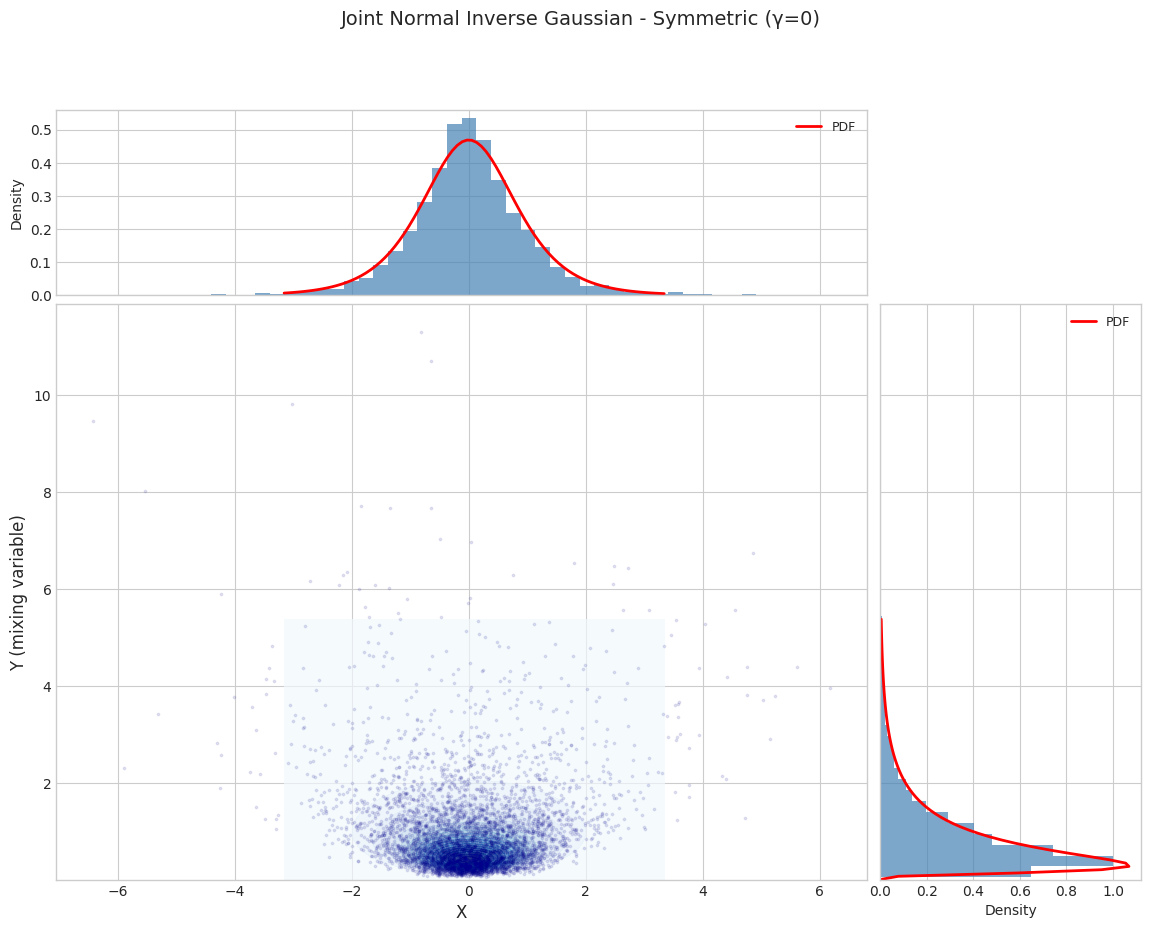


Parameter Set 2: Right-skewed (γ>0)


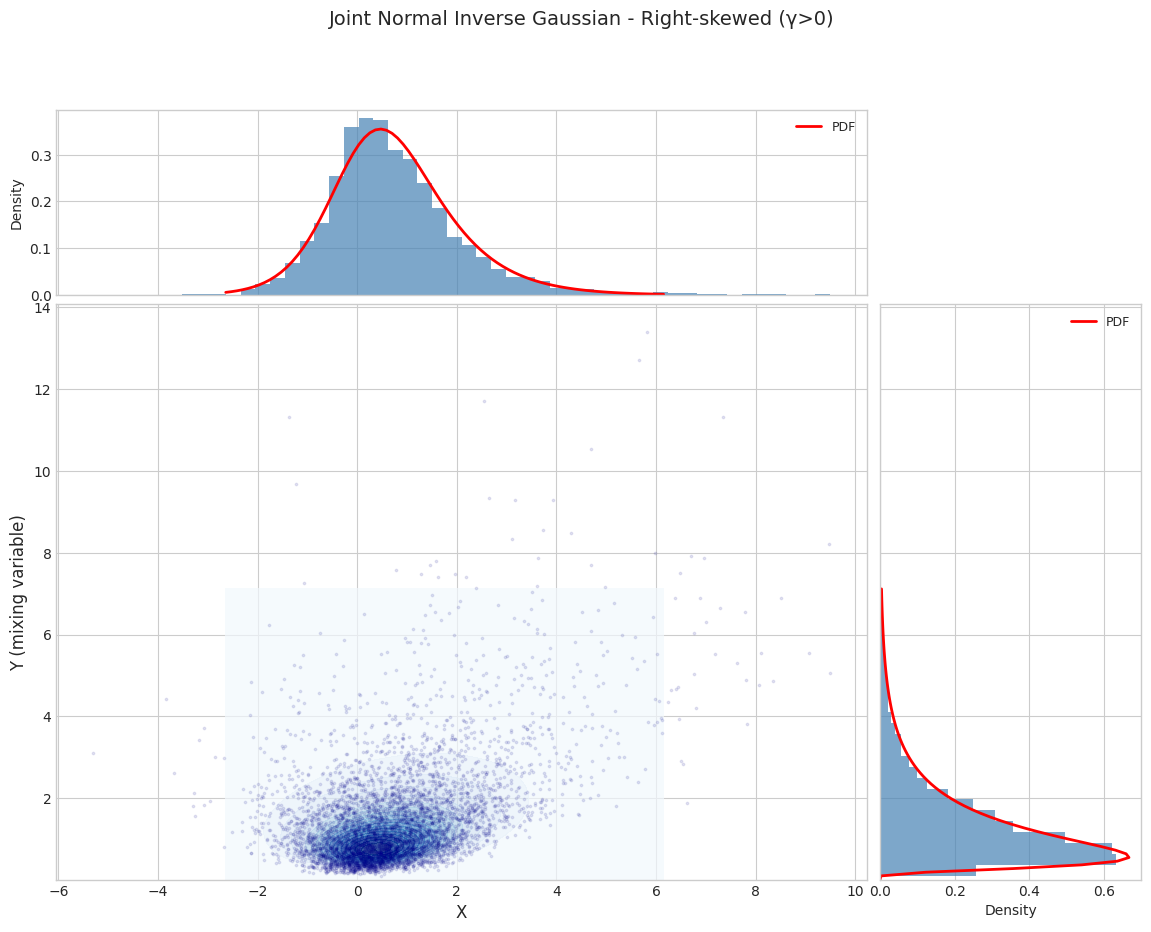


Parameter Set 3: Left-skewed (γ<0)


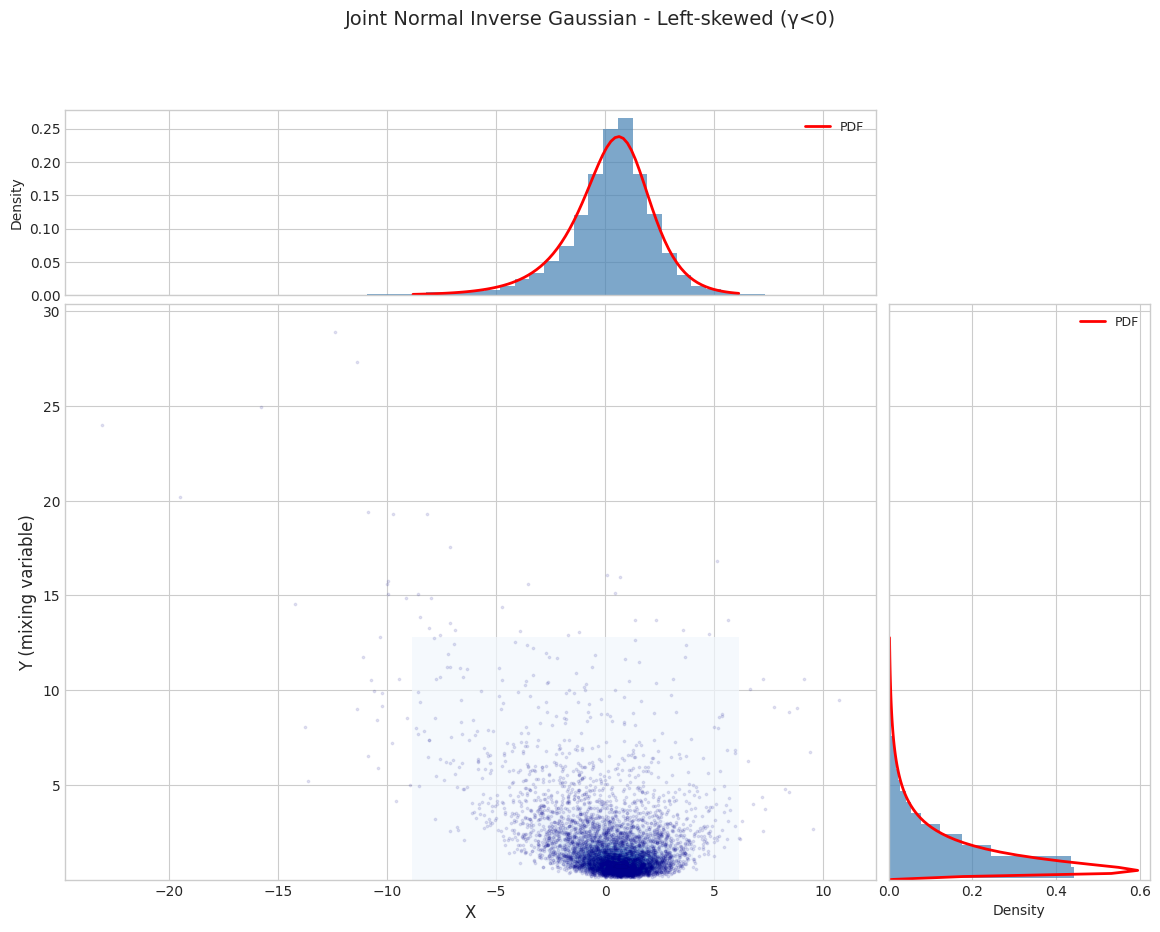

In [4]:
N_SAMPLES = 5000

for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    joint_dist = JointNormalInverseGaussian.from_classical_params(**params_1d)
    
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    fig = plot_joint_distribution_1d(
        joint_dist, 
        n_samples=N_SAMPLES, 
        random_state=42,
        title=f"Joint Normal Inverse Gaussian - {params['name']}"
    )
    plt.show()

## 1.2 Moment Validation (Joint)

In [5]:
for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    joint_dist = JointNormalInverseGaussian.from_classical_params(**params_1d)
    
    results = validate_moments(joint_dist, n_samples=50000, random_state=42, is_joint=True)
    print_moment_validation(results, f"Joint NIG - {params['name']}")


Moment Validation: Joint NIG - Symmetric (γ=0)
X_mean    : sample =    -0.0009, theory =     0.0000, rel_err = 9.03e+06
Y_mean    : sample =     1.0028, theory =     1.0000, rel_err = 2.79e-03
X_var     : sample =     1.0206, theory =     1.0000, rel_err = 2.06e-02
Y_var     : sample =     1.0209, theory =     1.0000, rel_err = 2.09e-02

Moment Validation: Joint NIG - Right-skewed (γ>0)
X_mean    : sample =     0.7513, theory =     0.7500, rel_err = 1.68e-03
Y_mean    : sample =     1.5044, theory =     1.5000, rel_err = 2.91e-03
X_var     : sample =     1.9634, theory =     1.9219, rel_err = 2.16e-02
Y_var     : sample =     1.7077, theory =     1.6875, rel_err = 1.20e-02

Moment Validation: Joint NIG - Left-skewed (γ<0)
X_mean    : sample =     0.1963, theory =     0.2000, rel_err = 1.83e-02
Y_mean    : sample =     2.0050, theory =     2.0000, rel_err = 2.49e-03
X_var     : sample =     4.9320, theory =     4.8533, rel_err = 1.62e-02
Y_var     : sample =     5.4041, theory =     5.

## 1.3 Joint Distribution Fitting (Exponential Family MLE)

In [6]:
for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    
    fitted_dist, fitted_params, param_errors = test_joint_fitting(
        JointNormalInverseGaussian, 
        params_1d, 
        n_samples=N_SAMPLES, 
        random_state=42
    )
    print_fitting_results(params_1d, fitted_params, param_errors, f"Joint NIG - {params['name']}")


Fitting Results: Joint NIG - Symmetric (γ=0)
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000         -0.0141     1.41e+08
gamma                    0.0000          0.0137     1.37e+08
sigma                    1.0000          0.9988     1.20e-03
delta                    1.0000          0.9806     1.94e-02
eta                      1.0000          1.0179     1.79e-02

Fitting Results: Joint NIG - Right-skewed (γ>0)
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000         -0.0177     1.77e+08
gamma                    0.5000          0.5106     2.12e-02
sigma                    1.0000          0.9988     1.16e-03
delta                    1.5000          1.4772     1.52e-02
eta                      2.0000          2.0356     1.78e-02

Fitting Results: Joint NIG - Left-skewed (γ<0)
Par

---
# Part 2: Marginal Distribution (2D X)

The marginal distribution $f(x) = \int f(x, y) dy$ is **NOT** an exponential family.

Fitting requires the **EM algorithm**.

## 2.1 Marginal Distribution Visualization


Parameter Set 1: Symmetric (γ=0)


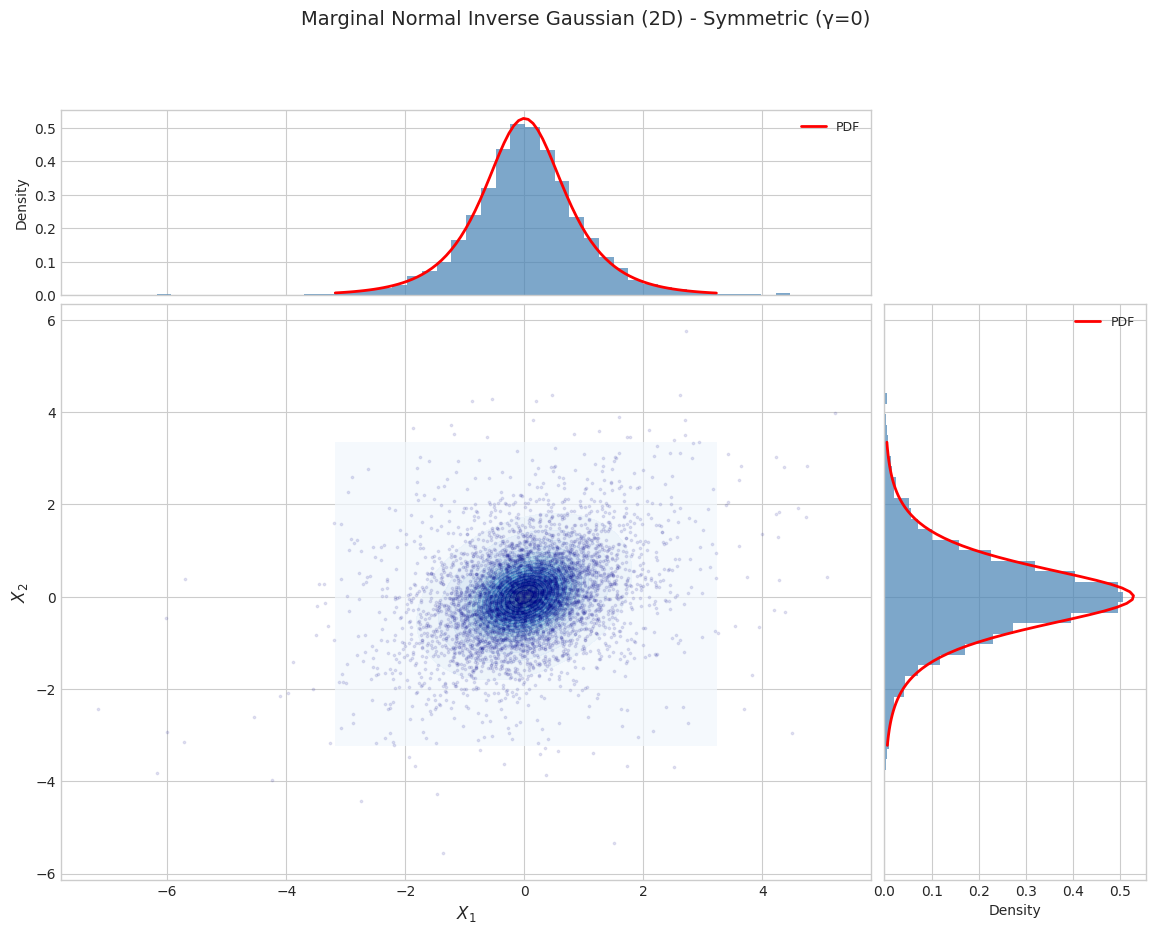


Parameter Set 2: Right-skewed (γ>0)


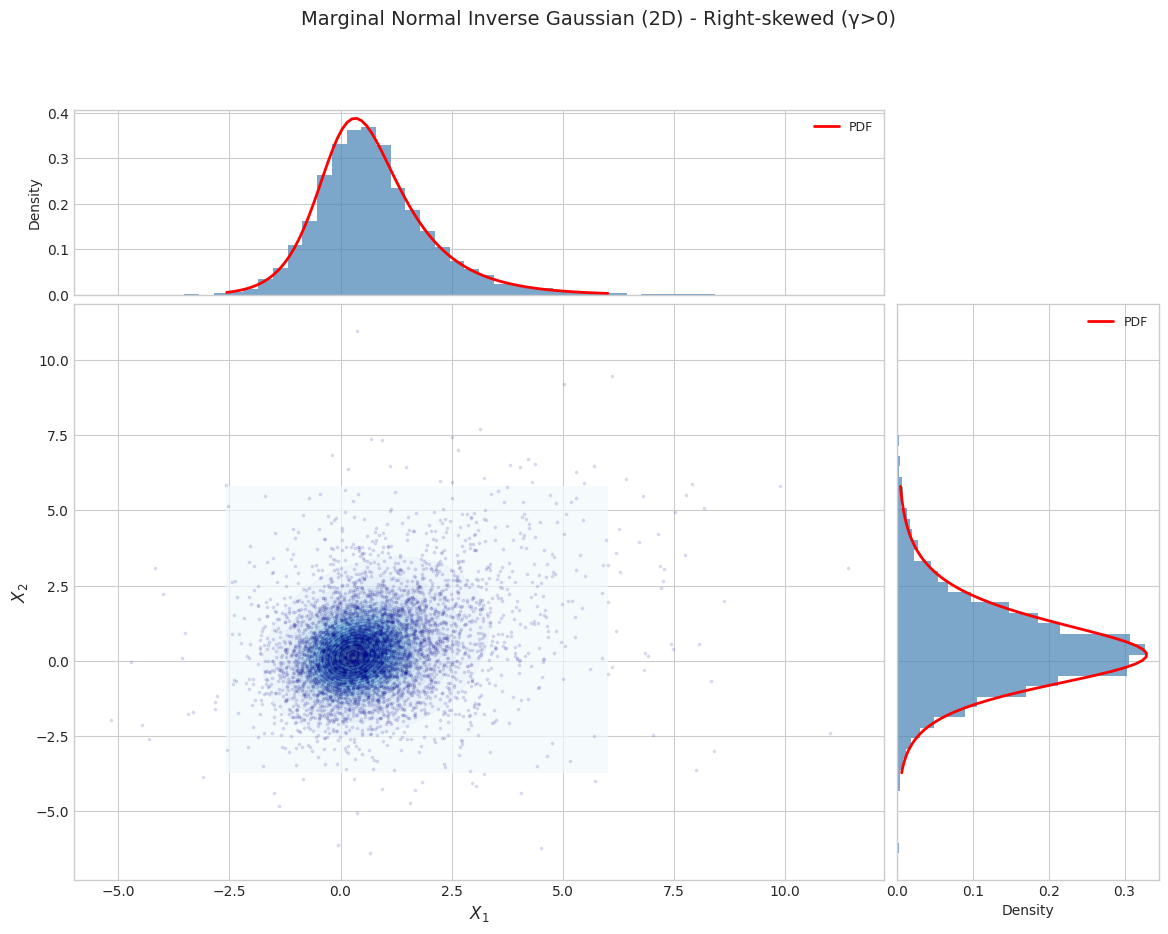


Parameter Set 3: Left-skewed (γ<0)


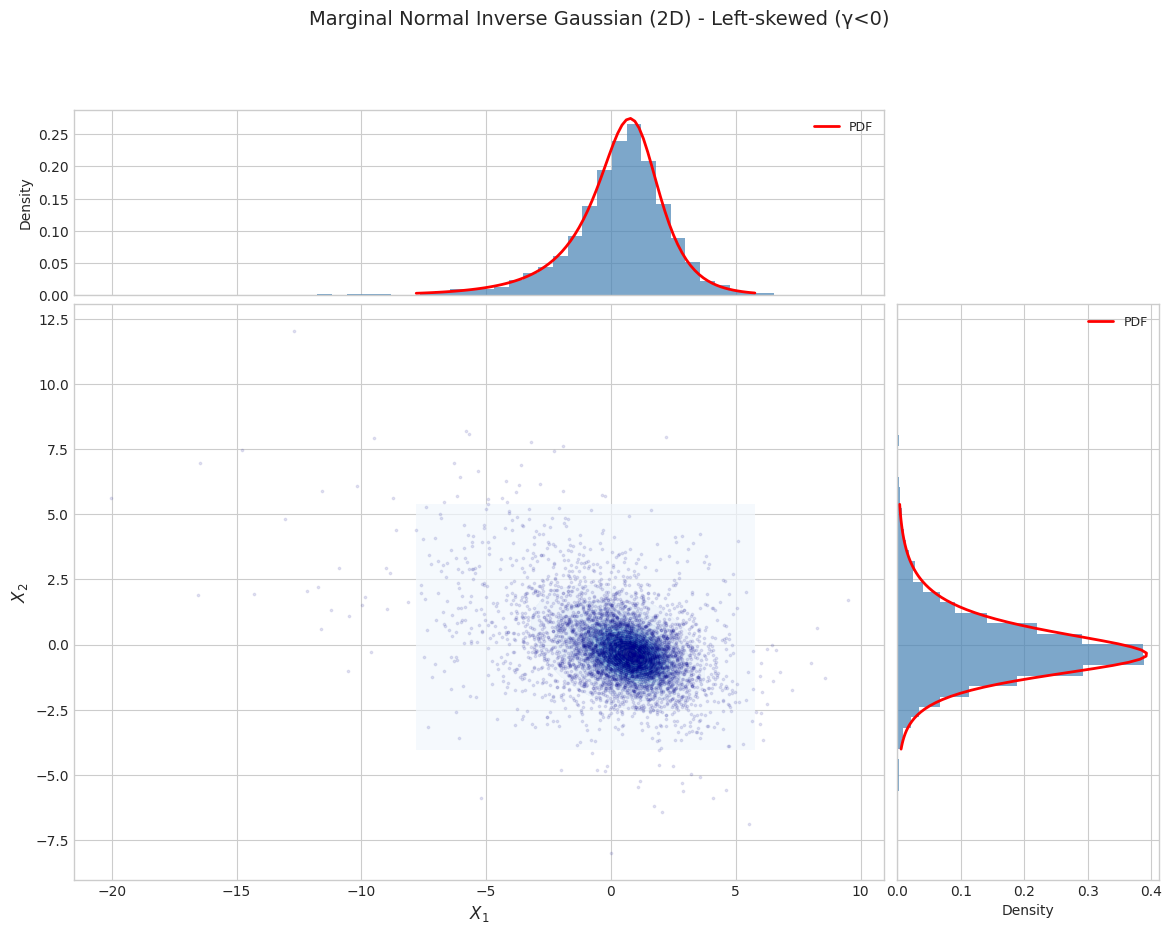

In [7]:
for i, params in enumerate(PARAM_SETS):
    marginal_dist = NormalInverseGaussian.from_classical_params(**params)
    
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    fig = plot_marginal_distribution_2d(
        marginal_dist, 
        n_samples=N_SAMPLES, 
        random_state=42,
        title=f"Marginal Normal Inverse Gaussian (2D) - {params['name']}"
    )
    plt.show()

## 2.2 Moment Validation (Marginal)

In [8]:
for i, params in enumerate(PARAM_SETS):
    marginal_dist = NormalInverseGaussian.from_classical_params(**params)
    
    results = validate_moments(marginal_dist, n_samples=50000, random_state=42, is_joint=False)
    print_moment_validation(results, f"Marginal NIG - {params['name']}")


Moment Validation: Marginal NIG - Symmetric (γ=0)
mean      :
  sample = [0.0048 0.0031]
  theory = [0. 0.]
  rel_err = [47529792.35 31132175.93]
variance  :
  sample = [1.0095 1.003 ]
  theory = [1. 1.]
  rel_err = [0.01 0.  ]

Moment Validation: Marginal NIG - Right-skewed (γ>0)
mean      :
  sample = [0.7577 0.4542]
  theory = [0.75 0.45]
  rel_err = [0.01 0.01]
variance  :
  sample = [1.9515 2.4097]
  theory = [1.9219 2.4019]
  rel_err = [0.02 0.  ]

Moment Validation: Marginal NIG - Left-skewed (γ<0)
mean      :
  sample = [ 0.2067 -0.0984]
  theory = [ 0.2 -0.1]
  rel_err = [0.03 0.02]
variance  :
  sample = [4.8635 2.2215]
  theory = [4.8533 2.2133]
  rel_err = [0. 0.]


## 2.3 EM Algorithm Fitting with Convergence Tracking


Parameter Set 1: Symmetric (γ=0)

Converged: True
Iterations: 12
Initial LL: -2.6579
Final LL:   -2.6575

Parameter Comparison:
  True δ = 1.0000, Fitted δ = 1.0040
  True η = 1.0000, Fitted η = 0.9793


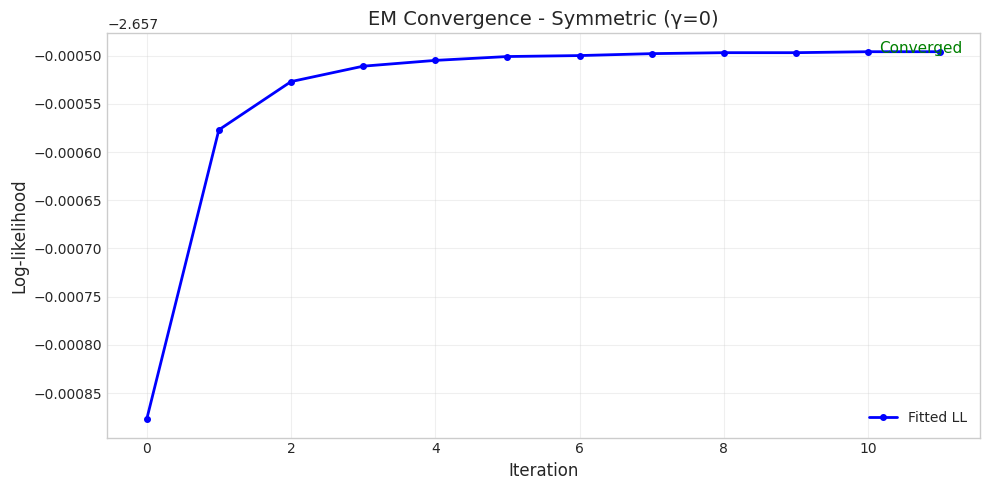


Parameter Set 2: Right-skewed (γ>0)

Converged: True
Iterations: 51
Initial LL: -3.4288
Final LL:   -3.4028

Parameter Comparison:
  True δ = 1.5000, Fitted δ = 0.9257
  True η = 2.0000, Fitted η = 1.1585


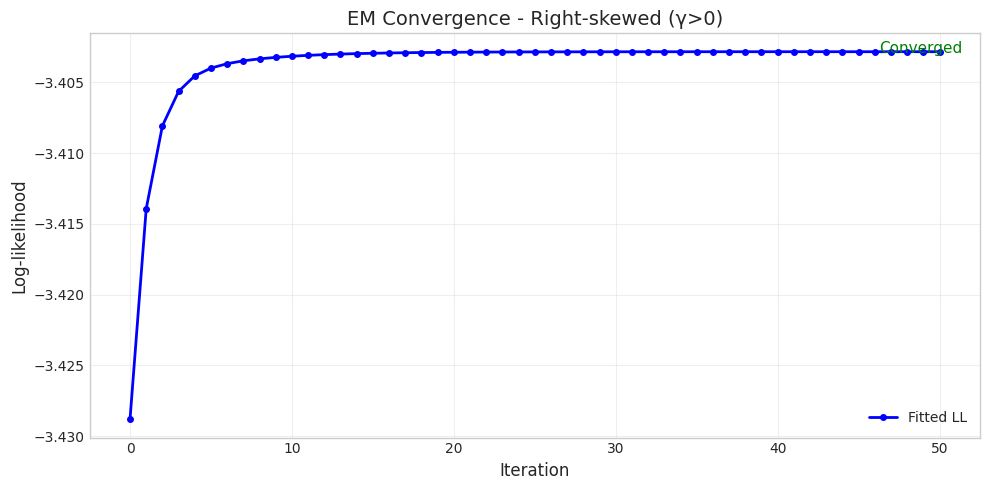


Parameter Set 3: Left-skewed (γ<0)

Converged: True
Iterations: 21
Initial LL: -3.6860
Final LL:   -3.6604

Parameter Comparison:
  True δ = 2.0000, Fitted δ = 1.0162
  True η = 1.5000, Fitted η = 0.7952


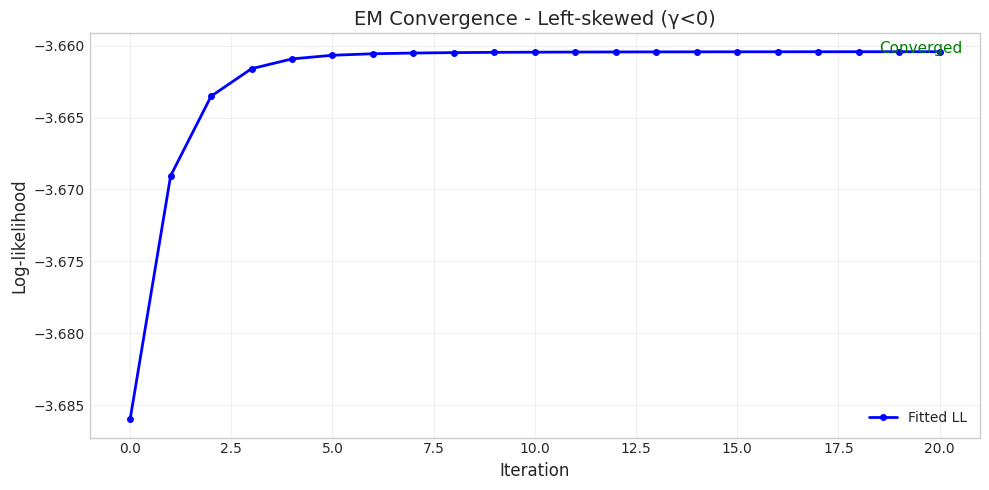

In [9]:
for i, params in enumerate(PARAM_SETS):
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    # Generate data from true distribution
    true_dist = NormalInverseGaussian.from_classical_params(**params)
    X_data = true_dist.rvs(size=N_SAMPLES, random_state=42)
    
    # Fit with EM and track convergence
    fitted_dist, convergence = fit_and_track_convergence(
        NormalInverseGaussian, 
        X_data, 
        max_iter=100, 
        random_state=43
    )
    
    # Print results
    print(f"\nConverged: {convergence.converged}")
    print(f"Iterations: {len(convergence.iterations)}")
    if convergence.log_likelihoods:
        print(f"Initial LL: {convergence.log_likelihoods[0]:.4f}")
        print(f"Final LL:   {convergence.log_likelihoods[-1]:.4f}")
    
    # Compare parameters
    print("\nParameter Comparison:")
    print(f"  True δ = {params['delta']:.4f}, Fitted δ = {convergence.final_params['delta']:.4f}")
    print(f"  True η = {params['eta']:.4f}, Fitted η = {convergence.final_params['eta']:.4f}")
    
    # Plot convergence
    if convergence.iterations:
        fig = plot_em_convergence(
            convergence,
            title=f"EM Convergence - {params['name']}"
        )
        plt.show()

---
# Part 3: Exponential Family Structure

The joint distribution has the exponential family form:

$$f(x, y | \theta) = h(x, y) \exp(\theta^T t(x, y) - \psi(\theta))$$

In [11]:
# Demonstrate exponential family structure
params_1d = get_1d_params(PARAM_SETS[1])  # Use right-skewed set
joint_dist = JointNormalInverseGaussian.from_classical_params(**params_1d)

print("Exponential Family Structure")
print("="*60)
print(f"\nClassical parameters:")
print(joint_dist.classical_params)

print(f"\nNatural parameters θ:")
print(joint_dist.natural_params)

print(f"\nExpectation parameters η = E[t(X,Y)]:")
print(joint_dist.expectation_params)

Exponential Family Structure

Classical parameters:
{'mu': array([0.]), 'gamma': array([0.5]), 'sigma': array([[1.]]), 'delta': np.float64(1.5), 'eta': np.float64(2.0)}

Natural parameters θ:
[-2.     -2.     -1.0139  0.5     0.     -0.5   ]

Expectation parameters η = E[t(X,Y)]:
[0.1172 1.1667 1.5    0.75   0.5    1.375 ]


In [13]:
# Verify E[t(X,Y)] matches expectation parameters
X_samples, Y_samples = joint_dist.rvs(size=50000, random_state=42)
t_samples = joint_dist._sufficient_statistics(X_samples, Y_samples)

eta_sample = np.mean(t_samples, axis=0)
eta_theory = joint_dist.expectation_params

print("\nVerification: E[t(X,Y)] from samples vs theory")
print("="*60)
print(f"Sample:     {eta_sample}")
print(f"Theory:     {eta_theory}")
print(f"Max error:  {np.max(np.abs(eta_sample - eta_theory)):.6f}")


Verification: E[t(X,Y)] from samples vs theory
Sample:     [0.1178 1.1691 1.5044 0.7513 0.4983 1.3865]
Theory:     [0.1172 1.1667 1.5    0.75   0.5    1.375 ]
Max error:  0.011455


---
# Summary

The **Normal Inverse Gaussian** distribution is a flexible model with:

| Feature | Description |
|---------|-------------|
| Mixing | $Y \sim \text{InvGauss}(\delta, \eta)$ |
| Skewness | Controlled by $\gamma$ |
| Tail behavior | Semi-heavy tails |
| Joint fitting | Exponential family MLE |
| Marginal fitting | EM algorithm |
| Special case | GH with $p = -1/2$ |